### Problem 3

In [74]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from colossus.cosmology import cosmology
from tqdm import tqdm
from scipy.stats import linregress

In [2]:
def my_plot_style():
    params = {'legend.fontsize': 10,
    'axes.labelsize': 15,
    'axes.titlesize':15,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'xtick.major.size':5,
    'xtick.minor.size':2.5,
    'ytick.major.size':5,
    'ytick.minor.size':2.5,
    'figure.facecolor':'w',
    #'lines.linewidth' : 1.5,
    'xtick.major.width':1.5,
    'ytick.major.width':1.5,
    'xtick.minor.width':1.5,
    'ytick.minor.width':1.5,
    'axes.linewidth':1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'ytick.labelleft':True,
    'text.usetex' : False,
    'font.family': 'sans-serif'}
    plt.rcParams.update(params)
my_plot_style()

In [3]:
class sample:
    def __init__(self,ra,dec,z,setdL=False):
        self.ra  = ra
        self.dec = dec
        self.z   = z
        self.rmag   = None
        self.d4000 = None
        self.pri = None
        self.sec = None
        self.dL = None
        
        self.sky = SkyCoord(ra,dec,unit='deg')
        if( setdL ):
            cosmo = cosmology.setCosmology('planck18')
            self.dL = cosmo.luminosityDistance(self.z)/(cosmo.H0/100)
    
    def select(self,vlimit):
        bools = []
        for vals in vlimit:
            v, vmin, vmax = vals[0], vals[1], vals[2]
            boolean = (vmin<v)&(v<vmax)
            bools.append(boolean)
        boolean = np.sum(bools,axis=0)==len(bools)
        new = sample(self.ra[boolean],self.dec[boolean],self.z[boolean],setdL=True)
        new.d4000 = self.d4000[boolean]
        new.rmag  = self.rmag[boolean]
        return new
        
    def create_sample(self,ralim,declim,sep=5):
        vlimit = [[self.ra,ralim[0],ralim[1]],[self.dec,declim[0],declim[1]]]
        self.sec = self.select(vlimit)
        vlimit = [[self.ra,ralim[0]+sep,ralim[1]-sep],[self.dec,declim[0]+sep,declim[1]-sep]]
        self.pri = self.select(vlimit)
        
    def count(self,limit): # rmax in Mpc, dvlim in km/s
        n = np.zeros([len(self.pri.z),len(limit)])
        for i, p in tqdm(enumerate(self.pri.sky)):
            sep = p.separation(self.sec.sky).degree*np.pi/180*self.pri.dL[i] # Mpc
            dv  = abs(self.pri.z[i]-self.sec.z)*3e5
            for j, lim in enumerate(limit):
                rmax, dvlim = lim[0],lim[1]
                legal = (sep<rmax)&(dv<dvlim)
                n[i,j] = np.sum(legal)
        return n
    
    def count_v2(self,limit):
        n = np.zeros([len(self.pri.z),len(limit)])
        for i in tqdm(range(len(self.pri.z))):
            sep = np.sqrt((self.pri.ra[i]-self.sec.ra)**2.0+(self.pri.dec[i]-self.sec.dec)**2.0)\
                   *np.pi/180*self.pri.dL[i] # Mpc
            dv  = abs(self.pri.z[i]-self.sec.z)*3e5
            for j, lim in enumerate(limit):
                rmax, dvlim = lim[0],lim[1]
                legal = (sep<rmax)&(dv<dvlim)
                n[i,j] = np.sum(legal)
        return n

In [4]:
name = 'D://GoogleLimin/110-2/Galaxy/hw03/mpavagc_simp.fits'
hdul = pf.open(name)
hdul[1].header
yt = sample(hdul[1].data['RA'],hdul[1].data['DEC'],hdul[1].data['Z'])
yt.d4000 = hdul[1].data['D4000_N_SUB']
hdul.close()

name = 'D://GoogleLimin/110-2/Galaxy/hw03/nsa_v1_0_1.fits'
hdul = pf.open(name)
nsa = sample(hdul[1].data['RA'],hdul[1].data['DEC'],hdul[1].data['Z'])
nsa.rmag = hdul[1].data['SERSIC_ABSMAG'][:,4]
hdul.close()

In [5]:
def match(yt,nsa,sep=1,dz=0.001):
    idx,d2d,d3d = (yt.sky).match_to_catalog_sky(nsa.sky)
    bool1 = d2d<(sep/3600)*u.deg
    bool2 = abs(yt.z-nsa.z[idx])<0.001
    boolean = bool1&bool2
    
    mysample = sample(yt.ra[boolean],yt.dec[boolean],yt.z[boolean])
    mysample.d4000 = yt.d4000[boolean]
    mysample.rmag  = nsa.rmag[idx[boolean]]
    return mysample
mysample = match(yt,nsa)
print(f'Sample size {len(mysample.z)}')

Sample size 535752


In [8]:
vlimit = [[mysample.z,0.02,0.1],[mysample.rmag,-100,-20]]
sample1 = mysample.select(vlimit)
sample1.create_sample([100,270],[min(sample1.dec),max(sample1.dec)])

In [7]:
vlimit = [[mysample.z,0.02,0.065],[mysample.rmag,-100,-19]]
sample2 = mysample.select(vlimit)
sample2.create_sample([100,270],[min(sample2.dec),max(sample2.dec)])

Text(0, 0.5, 'r-band magnitude')

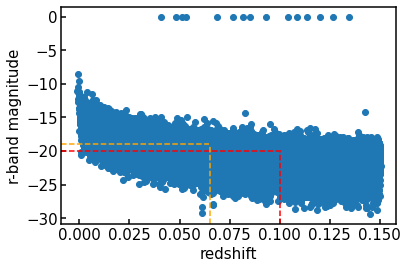

In [67]:
plt.scatter(mysample.z,mysample.rmag)
plt.axvline(0.1,0,10/30,ls='--',c='red')
plt.axhline(-20,0,0.112/0.17,ls='--',c='red')
plt.axvline(0.065,0,11/30,ls='--',c='orange')
plt.axhline(-19,0,0.044/0.1,ls='--',c='orange')
plt.xlabel('redshift')
plt.ylabel('r-band magnitude')

In [9]:
lim = [[1,250],[3,250],[5,250]]
sample1_result = sample1.count_v2(lim)
sample2_result = sample2.count_v2(lim)

100%|███████████████████████████████████████████████████████████████████████████| 78913/78913 [01:20<00:00, 980.46it/s]


In [128]:
def get_d4000(sample,result,select=[]):
    pool = sample.pri.d4000
    if( len(select)!=0 ):
        result = result[select]
        pool   = pool[select]
        print(f'Using sample {np.sum(select)}')
    nn = np.arange(1,int(max(result))+1)
    d4000 = []
    for i in range(int(max(result))):
        samp = result==(i+1)
        if( np.sum(samp)!=0 ): d4000.append([np.mean(pool[samp]),np.std(pool[samp])])
        else: d4000.append([-1,-1])
    return nn,np.array(d4000)

def get_kauff(sample,result,select=[]):
    pool = sample.pri.d4000
    if( len(select)!=0 ):
        result = result[select]
        pool   = pool[select]
        print(f'Using sample {np.sum(select)}')
    n = 150
    idx = np.argsort(result)
    result, pool = result[idx], pool[idx]
    nn, d4000 = [], []
    for i in range(int(len(pool)//n)):
        nn.append(np.median(result[i*n:(i+1)*n]))
        d4000.append([np.median(pool[i*n:(i+1)*n]),np.std(pool[i*n:(i+1)*n])])
    return np.array(nn),np.array(d4000)

Using sample 26160
Using sample 115494


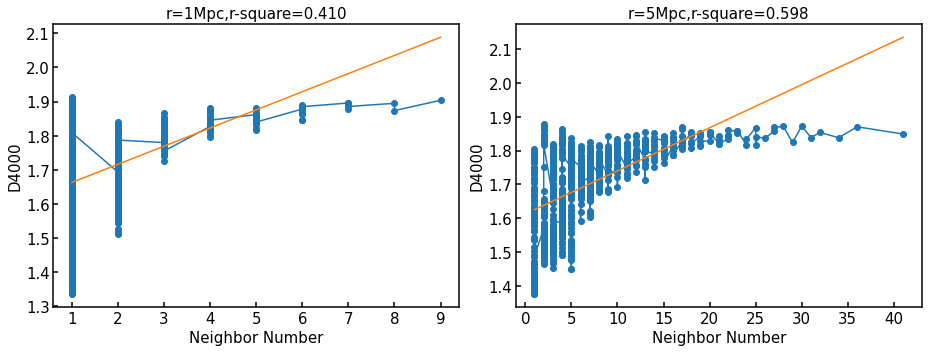

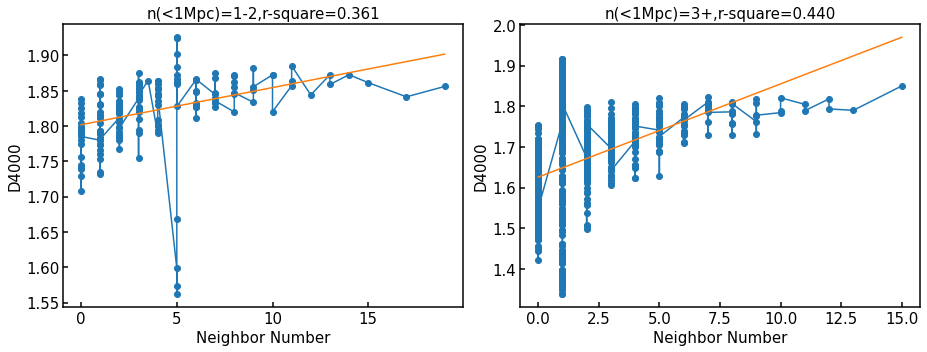

In [129]:
plt.figure(figsize=(13,5))
titles = ['r=1Mpc','r=5Mpc']
for i,idx in enumerate([0,2]):
    plt.subplot(1,2,i+1)
    result = sample1_result[:,idx]
    nn, d4000 = get_kauff(sample1,result)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    #plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

select = sample1_result[:,0]>2
dn = sample1_result[:,1]-sample1_result[:,0]
plt.figure(figsize=(13,5))
titles = ['n(<1Mpc)=1-2','n(<1Mpc)=3+']
for i,idx in enumerate([select,~select]):
    plt.subplot(1,2,i+1)
    nn, d4000 = get_kauff(sample1,dn,select=idx)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    #plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

Using sample 26160
Using sample 115494


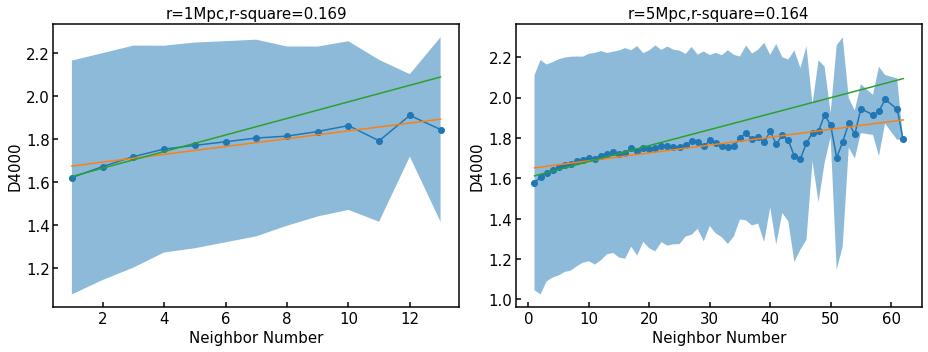

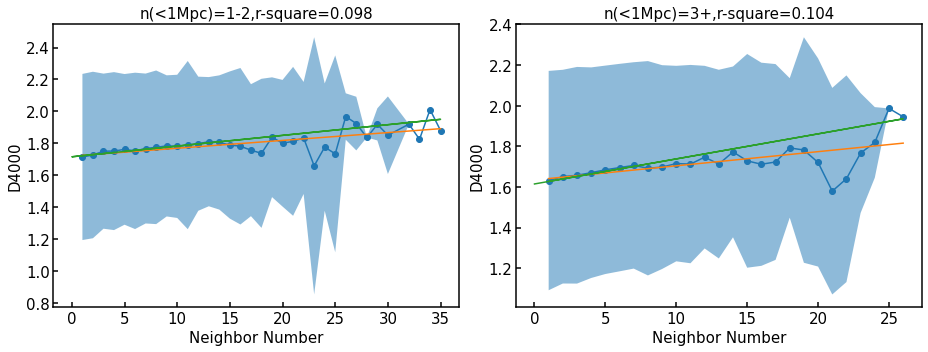

In [134]:
plt.figure(figsize=(13,5))
titles = ['r=1Mpc','r=5Mpc']
for i,idx in enumerate([0,2]):
    plt.subplot(1,2,i+1)
    result = sample1_result[:,idx]
    nn, d4000 = get_d4000(sample1,result)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    slope, intercept, r, p, se = linregress(result, sample1.pri.d4000)
    plt.plot(nn,slope*nn+intercept)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

select = sample1_result[:,0]>2
dn = sample1_result[:,1]-sample1_result[:,0]
plt.figure(figsize=(13,5))
titles = ['n(<1Mpc)=1-2','n(<1Mpc)=3+']
for i,idx in enumerate([select,~select]):
    plt.subplot(1,2,i+1)
    nn, d4000 = get_d4000(sample1,dn,select=idx)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    slope, intercept, r, p, se = linregress(dn[idx], sample1.pri.d4000[idx])
    plt.plot(dn[idx],slope*dn[idx]+intercept)
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

Using sample 26109
Using sample 52804


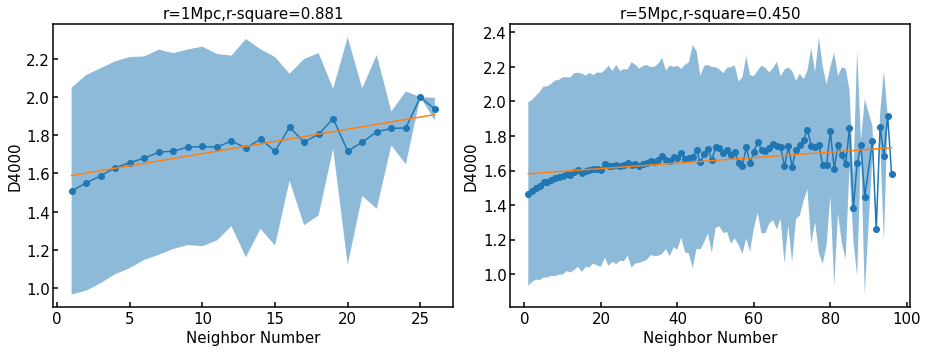

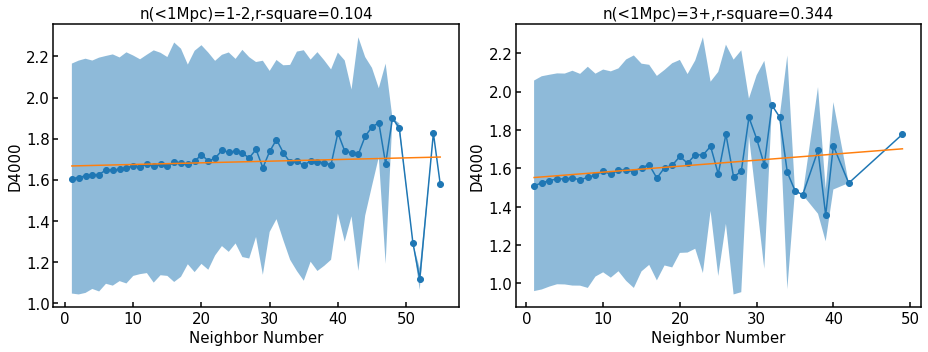

In [113]:
plt.figure(figsize=(13,5))
titles = ['r=1Mpc','r=5Mpc']
for i,idx in enumerate([0,2]):
    plt.subplot(1,2,i+1)
    result = sample2_result[:,idx]
    nn, d4000 = get_d4000(sample2,result)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

select = sample2_result[:,0]>2
dn = sample2_result[:,1]-sample2_result[:,0]
plt.figure(figsize=(13,5))
titles = ['n(<1Mpc)=1-2','n(<1Mpc)=3+']
for i,idx in enumerate([select,~select]):
    plt.subplot(1,2,i+1)
    nn, d4000 = get_d4000(sample2,dn,select=idx)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

In [108]:
lim = [[1,500],[3,500],[5,500]]
sample3_result = sample1.count_v2(lim)
sample4_result = sample2.count_v2(lim)

100%|██████████████████████████████████████████████████████████████████████████| 78913/78913 [01:09<00:00, 1130.15it/s]


Using sample 38389
Using sample 103265


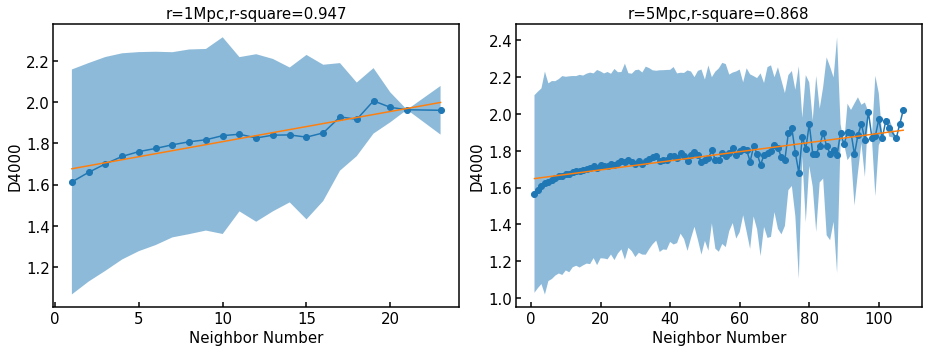

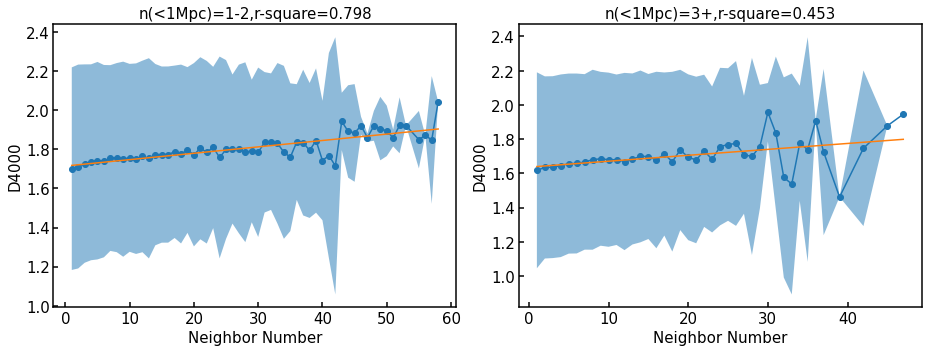

In [111]:
plt.figure(figsize=(13,5))
titles = ['r=1Mpc','r=5Mpc']
for i,idx in enumerate([0,2]):
    plt.subplot(1,2,i+1)
    result = sample3_result[:,idx]
    nn, d4000 = get_d4000(sample1,result)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

select = sample3_result[:,0]>2
dn = sample3_result[:,1]-sample3_result[:,0]
plt.figure(figsize=(13,5))
titles = ['n(<1Mpc)=1-2','n(<1Mpc)=3+']
for i,idx in enumerate([select,~select]):
    plt.subplot(1,2,i+1)
    nn, d4000 = get_d4000(sample1,dn,select=idx)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

Using sample 32467
Using sample 46446


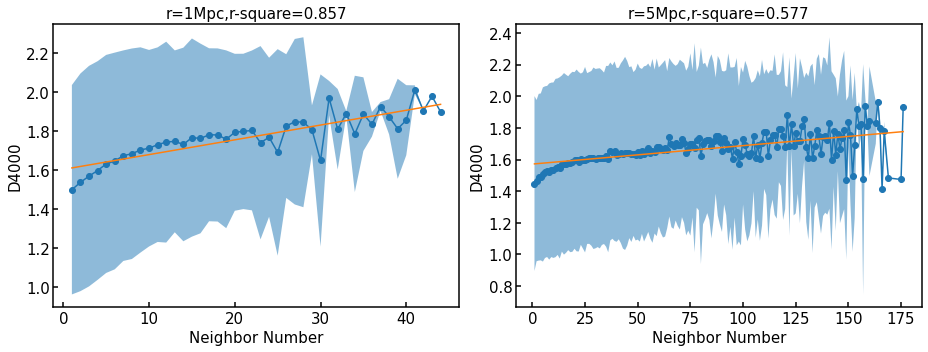

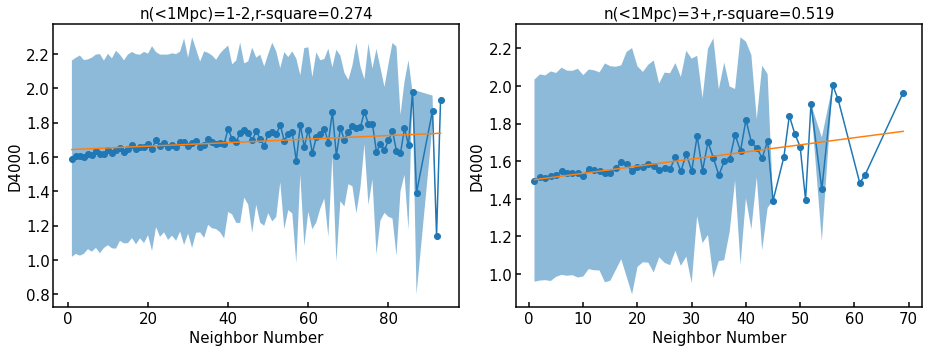

In [114]:
plt.figure(figsize=(13,5))
titles = ['r=1Mpc','r=5Mpc']
for i,idx in enumerate([0,2]):
    plt.subplot(1,2,i+1)
    result = sample4_result[:,idx]
    nn, d4000 = get_d4000(sample2,result)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()

select = sample4_result[:,0]>2
dn = sample4_result[:,1]-sample4_result[:,0]
plt.figure(figsize=(13,5))
titles = ['n(<1Mpc)=1-2','n(<1Mpc)=3+']
for i,idx in enumerate([select,~select]):
    plt.subplot(1,2,i+1)
    nn, d4000 = get_d4000(sample2,dn,select=idx)
    boolean = d4000[:,0]!=-1
    nn, d4000 = nn[boolean],d4000[boolean]
    plt.plot(nn,d4000[:,0],'-o')
    slope, intercept, r, p, se = linregress(nn, d4000[:,0])
    plt.plot(nn,slope*nn+intercept)
    plt.fill_between(nn,d4000[:,0]+2*d4000[:,1],d4000[:,0]-2*d4000[:,1],alpha=0.5)
    plt.title(titles[i]+f',r-square={r:.3f}')
    plt.xlabel('Neighbor Number')
    plt.ylabel('D4000')
plt.tight_layout()